In [120]:
import sys
import numpy as np
import torch
from deepymod_maxwell.data.maxwell import calculate_strain_stress
from deepymod_maxwell.model.library import auto_deriv

# Deepmod stuff
from deepymod_maxwell import DeepMoD
from deepymod_maxwell.model.func_approx import NN, Siren
from deepymod_maxwell.model.library import LibraryMaxwell
from deepymod_maxwell.model.constraint import LeastSquares
from deepymod_maxwell.model.sparse_estimators import Clustering, Threshold
from deepymod_maxwell.training import train, train_mse
from deepymod_maxwell.training.sparsity_scheduler import Periodic

import torch.autograd as auto


np_seed = 2
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)


%load_ext autoreload
%autoreload 2

# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
##

input_type = 'Strain'

# For Boltzmann DG, specific model required for calculation of response given manipulation type. Strain -> GMM, Stress -> GKM.
# For odeint method, no need to consider.
# mech_model = 'GMM' 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:

E = [1, 1, 2]
eta = [2.5, 5.0]

##

omega, omega2, omega3 =1, 0.25, 0.5
Amp, Amp2 = 2, 5
input_expr = lambda t: Amp*(1-np.exp(-omega*t)) + Amp2*(1-np.exp(-omega2*t)) + 0.2*np.cos(omega3*t)
d_input_expr = lambda t: Amp*omega*np.exp(-omega*t) + Amp2*omega2*np.exp(-omega2*t) -0.2*omega3*np.sin(omega3*t)
input_torch_lambda = lambda t: Amp*(1-torch.exp(-omega*t)) + Amp2*(1-torch.exp(-omega2*t)) + 0.2*torch.cos(omega3*t)

##
time_array = np.linspace(10**-4, 30, 2000).reshape(-1, 1)


strain_array, stress_array = calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

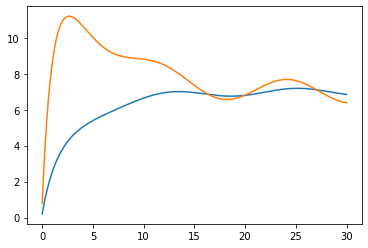

In [165]:
plt.plot(time_array,strain_array)
plt.plot(time_array,stress_array)

In [166]:

##

# 'normalising'
time_sf = 1# omega/1.5
strain_sf = 1# 1/np.max(abs(strain_array))
stress_sf = 1# 1/np.max(abs(stress_array))
# print(time_sf, strain_sf, stress_sf)

scaled_time_array = time_array*time_sf
scaled_strain_array = strain_array*strain_sf
scaled_stress_array = stress_array*stress_sf
if input_type == 'Strain':
    scaled_input_expr = lambda t: strain_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: strain_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = scaled_stress_array
elif input_type == 'Stress':
    scaled_input_expr = lambda t: stress_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: stress_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = scaled_strain_array

##

number_of_samples = 1500

reordered_row_indices = np.random.permutation(scaled_time_array.size)

reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = scaled_target_array[reordered_row_indices, :][:number_of_samples]

##

time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)



input_data = scaled_input_torch_lambda(time_tensor)
input_derivs = auto_deriv(time_tensor, input_data, 3)
input_theta = torch.cat((input_data.detach(), input_derivs.detach()), dim=1)

network = NN(1, [40, 40, 40, 40], 1)  # Function approximator
library = LibraryMaxwell(3, input_theta, 'strain') # Library function
estimator = Threshold() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model


In [167]:
# Running model
sparsity_scheduler = Periodic(initial_epoch=40000, periodicity=2500) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [168]:
train_mse(model, time_tensor, target_tensor, optimizer, sparsity_scheduler, max_iterations=50000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       3075      6.15%             849s   -1.07e+01   7.73e-04   7.73e-04   7.60e+01 

KeyboardInterrupt: 

In [ ]:
train(model, time_tensor, target_tensor, optimizer, sparsity_scheduler, patience=5000, max_iterations=150000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       5475      3.65%            3860s   -1.34e+01   1.90e-04   3.47e-06   8.35e+01 

In [35]:
model.coeff()

AttributeError: 'DeepMoD' object has no attribute 'coeff'